<a href="https://colab.research.google.com/github/Bharath2/cube/blob/master/Copy_of_sac_iponhvc0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install mitdeeplearning
!pip install recordclass
!pip install box2d box2d-py box2d-kengz

     |████████████████████████████████| 2.1MB 7.7MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-cp37-none-any.whl size=2115441 sha256=222fca23ca69e19139f0a0e96782428f5b3895b07f7266bd9a296d68f0cccd52
  Stored in directory: /root/.cache/pip/wheels/af/dc/2a/5c3633135e7e4ef4fd31463cfa1942cb1bae7486ab94e7a2ad
Successfully built mitdeeplearning
     |████████████████████████████████| 163kB 9.2MB/s 
  Created wheel for recordclass: filename=recordclass-0.14.3-cp37-cp37m-linux_x86_64.whl size=344694 sha256=343bfa3c3d9240eca677450b559616d3693c07225b7873825b7f7c01425c6445
  Stored in directory: /root/.cache/pip/wheels/c2/fa/9f/abec56a7c5d6843a053f2aa53166c556be33c169438c57e483
Successfully built recordclass
     |████████████████████████████████| 1.3MB 8.2MB/s 
     |████████████████████████████████| 450kB 48.5MB/s 
     |████████████████████████████████| 430kB 44.0MB/s 
  ERROR: Failed building wheel for box2d-kengz
  Running setup.py clean for box2d-kengz
Failed to b

In [ ]:
import time, gym
from gym import spaces
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import count
from scipy.integrate import solve_ivp

In [ ]:
from pyvirtualdisplay import Display
from mitdeeplearning.lab3 import play_video
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def save_video(env, model, name):
    display = Display(visible=0, size=(400, 300))
    display.start()

    filename = name + ".mp4"
    video_recorder = VideoRecorder(env, filename, enabled=True)
    
    counter = 0
    action = [0]
    done = 0
    obs = env.reset()
    while not done:
        env.render()
        video_recorder.capture_frame() 
        action = model(obs)
        obs, reward, done, info = env.step(action)
        counter += 1

    video_recorder.close()
    video_recorder.enabled = False
    print("Successfully saved {} frames into {}!".format(counter, filename))
    return filename

# **Environment**

In [ ]:
def angle_clip(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)

In [ ]:
class IPHVC(gym.Env):
    metadata = {
        'render.modes': ['human','rgb_array'],
        'video.frames_per_second': 30
    }

    def __init__(self):
        super(IPHVC,self).__init__()
        self.viewer = None
        self.counter = 0
        self.maxsteps = 1000 # need more time than 500

        self.mp = 0.25
        self.Jp = 0.0075
        self.lp = 1.0 # eases instead of 0.6; redo equations of motion with lpc later
        self.mc = 10
        self.g = 9.81
        self.w = 10.25*9.81

        self.xmax = 2 # more realistic instead of 0.3
        self.ymax = 1

        self.fscale = np.array([40, 90])
        self.state = np.array([0, 0, 0, 0, 0, 0])
        self.action_space = spaces.Box(low=-1*np.ones((2,)), high=1*np.ones((2,)), dtype=np.float32)
        self.observation_space = spaces.Box(low=-100*np.ones((6,)),high=100*np.ones((6,)),dtype=np.float32)

    def reset(self):
        self.counter = 0
        self.state = np.array([np.pi+np.random.normal(0, 0.1), 0, 0, #
                                     np.random.normal(0, 0.1), 0, 0])
        self.state[0] = angle_clip(self.state[0])
        return self.state
    
    def dynamics(self, q, qd):
        mp, Jp, lp, mc, g = self.mp, self.Jp, self.lp, self.mc, self.g

        M = np.array([[Jp + lp**2*mp/4,  -mp*lp*np.cos(q)/2, -mp * lp * np.sin(q)/2],
                      [-mp*lp*np.cos(q)/2, mc + mp,    0],
                      [-mp*lp*np.sin(q)/2,    0,    mc + mp]])
        
        C = np.array([[0],
                      [mp * lp * qd**2 * np.sin(q)/2],
                      [-mp * lp * qd**2 * np.cos(q)/2]])
        
        G = np.array([[-mp*g*lp*np.sin(q)/2],
                      [0],
                      [mc*g + mp*g]])
        
        return M, C, G


    def state_dot(self, t, state, tau):
        q, xc, yc, qd, xcd, ycd = state

        M, C, G = self.dynamics(q, qd)

        Minv = np.linalg.inv(M)

        acc = Minv@(tau - C - G)

        state_dot = np.r_[qd, xcd, ycd, acc[0], acc[1], acc[2]]

        return state_dot


    def step(self, action):
        self.counter += 1

        tau = np.r_[0, self.fscale*action]
        tau = (tau + np.array([0, 0, self.w])).reshape((3,1))

        self.state = solve_ivp(self.state_dot, (0, 0.01), self.state, args = (tau,), rtol=1e-8, atol=1e-8).y[:,-1]

        self.state[0] = angle_clip(self.state[0])
   
        reward = 0.1*(np.pi - abs(self.state[0]))**2

        if abs(self.state[1]) > self.xmax or abs(self.state[2]) > self.ymax:
            reward, done, info = -0.1, True, {'Terminal': 'Limit'}
        elif self.counter >= self.maxsteps:
            done, info = True, {'Terminal': 'Timeout'}
        else:
            done, info = False, {'Terminal': ''}


        return self.state, reward, done, info


    def render(self, mode='human'):
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(400,400)
            self.viewer.set_bounds(-1.0,1.0,-1.0,1.0)

            gnd = rendering.make_polygon([(-0.1-self.xmax,-0.1-self.ymax),
                                          ( 0.1+self.xmax,-0.1-self.ymax),
                                          ( 0.1+self.xmax, 0.1+self.ymax),
                                          (-0.1-self.xmax, 0.1+self.ymax)],filled=False)
            gnd.set_color(0.5, 0.5, 0.5)

            cart = rendering.make_polygon([(-0.1,-0.1),(0.1,-0.1),(0.1,0.1),(-0.1,0.1)],filled=True)
            cart.set_color(1, 0.4, 0.4)
            self.cartt = rendering.Transform(translation=(0,0))
            cart.add_attr(self.cartt)

            pend = rendering.make_capsule(0.6, 0.02)
            pend.set_color(0.3, 0.3, 0.8)
            self.pendt = rendering.Transform(rotation=self.state[0]+np.pi/2)
            pend.add_attr(self.pendt)

            self.viewer.add_geom(gnd)
            self.viewer.add_geom(cart)
            self.viewer.add_geom(pend)
        self.cartt.set_translation(self.state[1],self.state[2])
        self.pendt.set_translation(self.state[1],self.state[2])
        self.pendt.set_rotation(self.state[0]+np.pi/2)
        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [ ]:
#env = gym.make('BipedalWalker-v3')
env = IPHVC()
env.reset()

save_video(env, lambda x: [0]*4, 'a')
play_video('a.mp4')

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Successfully saved 600 frames into a.mp4!


In [ ]:
state_dim = 6
action_dim = 2

# **Import Torch**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.nn.utils import clip_grad_value_


# if gpu is to be used
if torch.cuda.is_available():
  device = torch.device("cuda")
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  device = torch.device("cpu")
  torch.set_default_tensor_type(torch.FloatTensor)

# Training Utils

In [ ]:
def optimize(model, optimizer, loss, clip_value = 1):
    optimizer.zero_grad()
    loss.backward()
    clip_grad_value_(model.parameters(), clip_value)
    optimizer.step()

In [ ]:
def soft_update(target, source, tau):
	for a, b in zip(target.parameters(), source.parameters()):
		a.data.copy_(a.data * (1.0 - tau) + b.data * tau)

# Util to Plot Reward

In [ ]:
from IPython import display as ipythondisplay

tic = time.time()
def plot(reward):
    global tic
    if time.time() - tic > 2:

      plt.cla()
      plt.grid(True)
      fig = plt.gcf()
      fig.set_size_inches(9,6)
      plt.plot(reward)
      plt.xlabel('episodes')
      plt.ylabel('rewards')

      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      tic = time.time()

# **Replay Memory**

In [ ]:
from recordclass import recordclass

Transitions = recordclass('Transitions', ('states', 'actions', 'next_states', 'rewards', 'dones'))

class ReplayMemory():
    def __init__(self, capacity = 1000, state_dim = 6, action_dim = 2):
      
        self.length = 0
        self.capacity = capacity

        self.states = np.zeros((capacity, state_dim))
        self.actions = np.zeros((capacity, action_dim))
        self.next_states = np.zeros((capacity, state_dim))
        self.rewards = np.zeros((capacity, 1))
        self.dones = np.zeros((capacity, 1))
      
    def add_transition(self, *args):
        index = self.length % self.capacity

        self.states[index] = args[0]
        self.actions[index] = args[1]
        self.next_states[index] = args[2]
        self.rewards[index] = args[3]
        self.dones[index] = args[4]

        self.length += 1

    def sample(self, batch_size):

        maxind = min(self.length, self.capacity)
        inds = np.random.choice(maxind, batch_size)

        batch = Transitions(self.states[inds],
                            self.actions[inds],
                            self.next_states[inds],
                            self.rewards[inds],
                            self.dones[inds])
        
        for i in range(5):
          batch[i] = torch.tensor(batch[i], dtype=torch.float)

        return batch
    
    def clear(self): 
      self.length = 0
        
    def __len__(self):
      return min(self.length, self.capacity)

# **Q-value Network**

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_dim = 6, action_dim = 2):
        super(DQN, self).__init__()
        self.l11 = nn.Linear(state_dim, 32)
        self.l12 = nn.Linear(action_dim, 8)

        self.l2 = nn.Linear(40, 128)
        self.l3 = nn.Linear(128, 256)

        self.last = nn.Linear(256, 1)
        self.last.weight.data.uniform_(-0.05,0.05)
        self.last.bias.data.fill_(0.01)

    def forward(self, states, actions):
        x = torch.cat((self.l11(states), self.l12(actions)),1)
        x = F.silu(x)
        x = F.silu(self.l2(x))
        x = F.silu(self.l3(x))
        x = self.last(x)
        return x

# **Double Q-Network Critic**

In [ ]:
class Critic(nn.Module):
  def __init__(self, state_dim = 6, action_dim = 2):
    super(Critic, self).__init__()
    self.q1 = DQN(state_dim, action_dim)
    self.q2 = DQN(state_dim, action_dim)
  
  def predict(self, states, actions):
    q1 = self.q1(states, actions)
    q2 = self.q2(states, actions)
    return q1, q2
  
  def forward(self, states, actions):
    q1, q2 = self.predict(states, actions)
    return torch.min(q1, q2)
  
  def calc_loss(self, states, actions, expected_critic_values):
    q1, q2 = self.predict(states, actions)
    loss1 = F.smooth_l1_loss(expected_critic_values, q1)
    loss2 = F.smooth_l1_loss(expected_critic_values, q2)
    return loss1 + loss2
  
  def requires_grad(self, boolean = True):
    for param in self.parameters():
        param.requires_grad = boolean

# **Policy Network**

In [ ]:
class Policy(nn.Module):

    def __init__(self, state_dim = 6, action_dim = 2):
        super(Policy, self).__init__()

        self.l1 = nn.Linear(state_dim, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128, 256)

        self.mean_layer = nn.Linear(256, action_dim)
        self.mean_layer.weight.data.uniform_(-0.01,0.01)
        self.mean_layer.bias.data.fill_(0.01)

        self.log_std = nn.Linear(256, action_dim)
        self.log_std.weight.data.uniform_(-0.5,0.5)
        self.log_std.bias.data.fill_(0.1)


    def forward(self, states):

        x = F.silu(self.l1(states))
        x = F.silu(self.l2(x))
        x = F.silu(self.l3(x))

        mean = self.mean_layer(x)
        std = torch.exp(self.log_std(x).clamp(-20, 2))

        return Normal(mean, std)

    def sample(self, states):

        dist = self.forward(states)
        samples = dist.rsample()
        actions = torch.tanh(samples)
        log_probs = dist.log_prob(samples) - torch.log(1 - actions**2 + 1e-8)
        
        return actions, log_probs.mean(axis = 1)

    def choose_action(self, state, training = True):
        
        with torch.no_grad(): 
          state = torch.tensor(state, dtype = torch.float).unsqueeze(0)
          dist = self.forward(state)
          sample = dist.sample() if training else dist.mean
          action = torch.tanh(sample).squeeze(0)

        return np.round(action.cpu().numpy(), 5)

# **Initialize**

In [ ]:
action_lim = np.array([1, 1])

In [ ]:
gamma = 0.99   # discount factor
alpha = 0.12   # entropy reward coeff

actor = Policy().to(device)
critic = Critic().to(device)

target_critic = Critic().to(device)
target_critic.load_state_dict(critic.state_dict())

<All keys matched successfully>

In [ ]:
actor_optimizer  = optim.Adam(actor.parameters(), 1e-3)
critic_optimizer = optim.Adam(critic.parameters(), 1e-3)

In [ ]:
memory = ReplayMemory(300000)

In [ ]:
def save(name):
  torch.save({
            'actor': actor.state_dict(),
            'critic': target_critic.state_dict(),
            'actor_optimizer': actor_optimizer.state_dict(),
            'critic_optimizer': critic_optimizer.state_dict(),
            }, name)

In [ ]:
def load(name, device):
  state = torch.load(name, map_location = device)

  actor.load_state_dict(state['actor'])
  critic.load_state_dict(state['critic'])
  actor_optimizer.load_state_dict(state['actor_optimizer'])
  critic_optimizer.load_state_dict(state['critic_optimizer'])

  target_critic.load_state_dict(critic.state_dict())

# **Single training step**

In [ ]:
def train_step(batch_size = 64):

    batch = memory.sample(batch_size)

  #---------------------critic training----------------------------------
    with torch.no_grad(): 
      next_actions, log_probs = actor.sample(batch.next_states)
      next_critic_values = target_critic(batch.next_states, next_actions)
      expected_critic_values = batch.rewards + (1 - batch.dones)*gamma*(next_critic_values - alpha*log_probs)

    critic_loss = critic.calc_loss(batch.states, batch.actions, expected_critic_values)

    optimize(critic, critic_optimizer, critic_loss)
  #---------------------------------------------------------------------


   #---------------------actor training----------------------------------
    critic.requires_grad(False)

    actions, log_probs = actor.sample(batch.states)
    critic_value = critic(batch.states, actions)
    actor_loss = -torch.mean(critic_value - alpha*log_probs)

    optimize(actor, actor_optimizer, actor_loss)

    critic.requires_grad(True)
  #-----------------------------------------------------------------------


  #----------------soft update target critic--------------------------------
    soft_update(target_critic, critic, 0.005)
  #-------------------------------------------------------------------------

In [ ]:
reward_list = []
avg_rewards = []

# **Training**

In [ ]:
len(memory)

0

In [ ]:
env = IPHVC()

while len(memory) < 5000:
  state = env.reset()
  done = 0
  while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    memory.add_transition(state, action, next_state, reward, done)
    
    # train_step()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


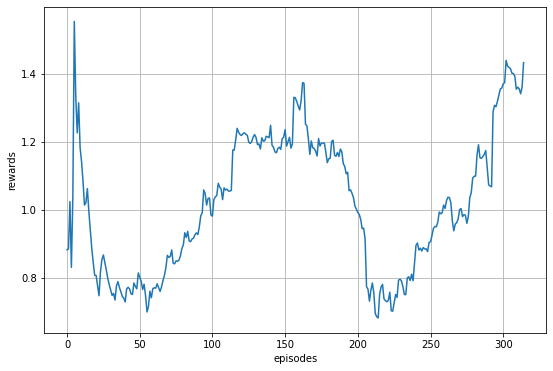

 16%|█▌        | 315/2000 [18:53<1:47:52,  3.84s/it]

In [ ]:
for i_episode in tqdm(range(2000)):

  state = env.reset()
  total_reward = 0
  done = 0
  steps = 0

  while not done:

    action = action_lim*actor.choose_action(state)
    # if np.random.uniform() < 0.1:
    #   action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    memory.add_transition(state, action, next_state, reward, done)

    total_reward += reward
    state = next_state
    steps += 1
  
  for _ in range(200):
    train_step()

  reward_list.append(total_reward)
  avg_rewards.append(np.mean(reward_list[-50:])) 

  plot(avg_rewards)

In [ ]:
save('best')

In [ ]:
load('best', device)

In [ ]:
policy = lambda x: action_lim * actor.choose_action(x, False)

In [ ]:
env.reset()

save_video(env, policy, 'a')
play_video('a.mp4')